In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'


import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

import matplotlib.pyplot as plt

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [4]:
datasetdir = '../../../../Data/training_dataset/'
print(os.listdir(datasetdir))
categories = np.load(os.path.join(datasetdir, 'categories.npy'))
training_data = np.load(os.path.join(datasetdir, 'training_data.npy'))
valid_periods = np.load(os.path.join(datasetdir, 'valid_periods.npy'))
print(categories.shape)
print(training_data.shape)
print(valid_periods.shape)

['categories.npy', 'training_data.npy', 'valid_periods.npy']
(48000,)
(48000, 2776)
(48000, 2)


In [5]:
length = [x[1]-x[0] for x in valid_periods]
print('Max length: ', max(length))
print('Min length: ', min(length))

Max length:  2776
Min length:  24


In [6]:
# Create a dictionary of data
data = {category: [] for category in categories}
for i, temp_data in enumerate(training_data):
    data[categories[i]].append(temp_data[valid_periods[i][0]:valid_periods[i][1]])


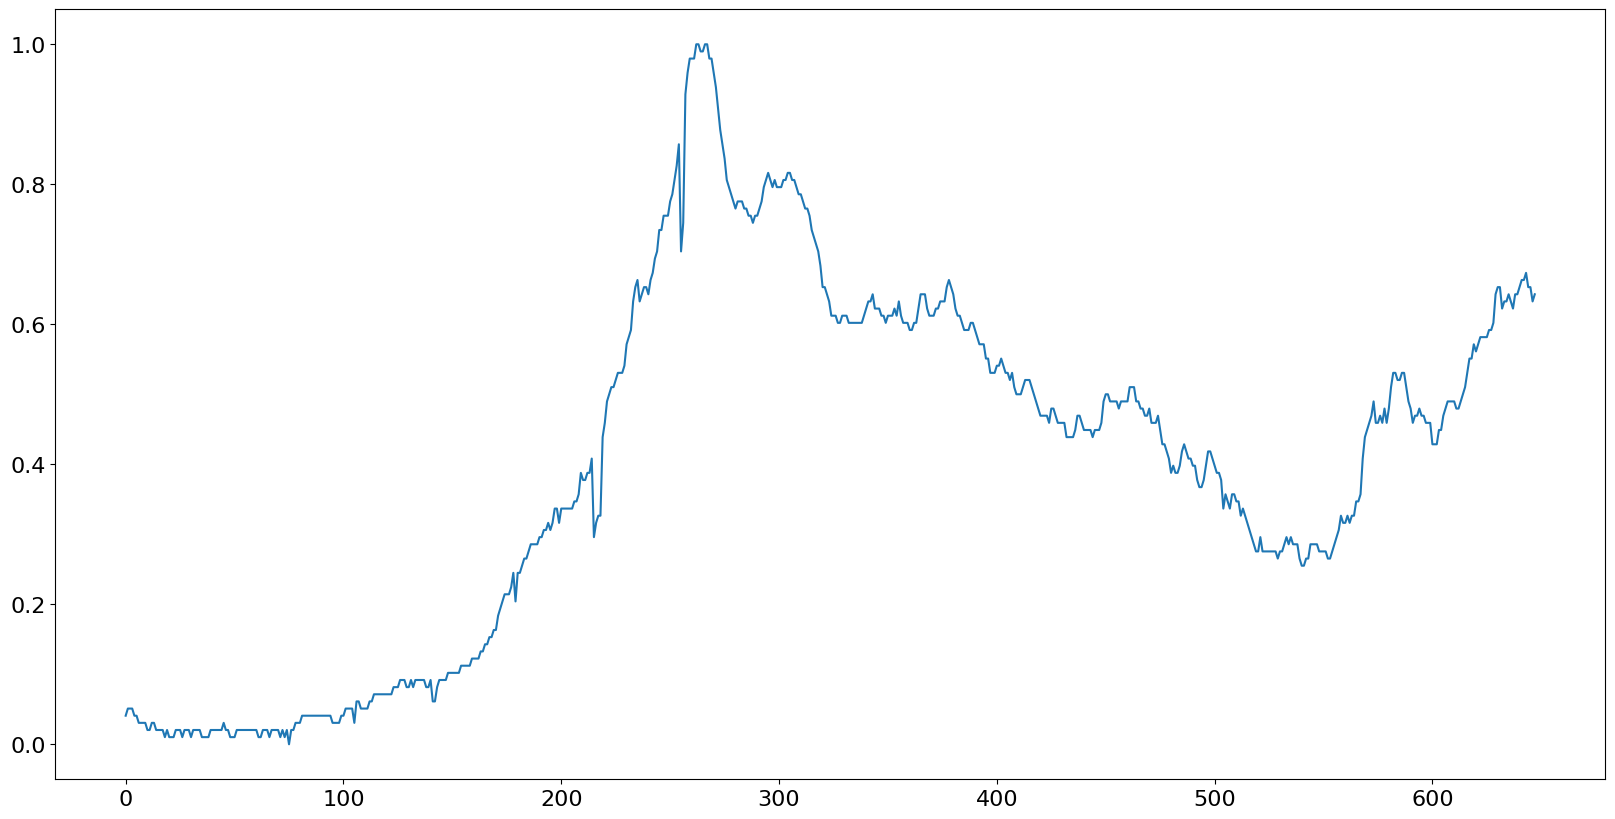

In [113]:
# Plot a sample of the data
category_index =    1     # 'A' 'B' 'C' 'D' 'E' 'F', 0-5
index = np.random.randint(0, len(data[categories[category_index]]))
index = 5
plt.figure(figsize=(20, 10))
plt.plot(data[categories[category_index]][index])
plt.show()


In [119]:
window = 60
stride = 5
# print(data[categories[1]])
print(len(data[categories[1]][5]))

x = (data[categories[1]][5][0:10])
x.append(data[categories[1]][5][10:20])
print(x)


648
[0.04081632653061224, 0.05102040816326531, 0.05102040816326531, 0.05102040816326531, 0.04081632653061224, 0.04081632653061224, 0.030612244897959183, 0.030612244897959183, 0.030612244897959183, 0.030612244897959183, array([0.02040816, 0.02040816, 0.03061224, 0.03061224, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.01020408, 0.02040816])]


In [120]:
# Idea train a model for each category and predict the category of the test data

# Check category distribution
category_distribution = {category: len(data[category]) for category in categories}
print(category_distribution)

# check the size o the data
# filtered_data = {category: [] for category in categories}
filtered_data = {}
for category in categories:
    for temp_data in data[category]:
        if len(temp_data) >= window:
            if category in filtered_data:
                filtered_data[category].append(temp_data)
            else:	
                filtered_data[category] = [temp_data]

# Check category distribution
category_distribution = {category: len(filtered_data[category]) for category in categories}
print(category_distribution)

{'D': 10016, 'E': 10975, 'A': 5728, 'C': 10017, 'B': 10987, 'F': 277}
{'D': 74458944, 'E': 74542200, 'A': 32787072, 'C': 91805805, 'B': 86753352, 'F': 60940}


In [124]:
# Use nicos code for data reading
# Constants
val_size = 0.2
data_path = 'training_dataset'
seq_length = 128     # predictions based on previous seq_length data entries
forecast_length = 9  # predicting forecast_length time steps into the future
sample_length = seq_length + forecast_length

In [126]:
training_data = np.load(os.path.join(datasetdir, 'training_data.npy'))
valid_periods = np.load(os.path.join(datasetdir, 'valid_periods.npy'))

# Filter out unvalid data
data = []
for i, row in enumerate(training_data):
    data.append(row[valid_periods[i][0]:valid_periods[i][1]])

print(f"({len(data)}, -)", valid_periods.shape)

(48000, -) (48000, 2)


In [127]:
# Convert time series to {x: sequences of length seq_length, y: values to be predicted from previous sequence}
def to_sequences(time_series):
    
    x = []
    y = []
    
    for i in range(time_series.shape[0]-seq_length-forecast_length+1):
        x.append(time_series[i:i+seq_length])
        y.append(time_series[i+seq_length:i+seq_length+forecast_length])  
    
    x = np.array(x)
    y = np.array(y)
    
    return {'x': x.reshape((x.shape[0], x.shape[1], -1)), 'y': y.reshape((y.shape[0], y.shape[1], -1))}

# Shuffle data
np.random.shuffle(data)
 
# Build sequences from the non-correlated time series, and append them to corresponding data set
# Note: there is no overlap between train and validation; each processed time series is used in train xor val
X_train, X_val = [], []
y_train, y_val = [], []
data = data
split_index = int((1-val_size)*len(data))
for i, time_series in enumerate(data): 
    if (len(time_series) >= sample_length): # assert we can draw at least one sample from the time_series
        sequences = to_sequences(time_series)
        if(i < split_index):
            X_train.append(sequences['x']) 
            y_train.append(sequences['y'])   
        else:
            X_val.append(sequences['x']) 
            y_val.append(sequences['y'])  

# Convert lists to nparrays 
X_train = np.concatenate(X_train, axis=0)
X_val = np.concatenate(X_val, axis=0)
y_train = np.concatenate(y_train, axis=0)
y_val = np.concatenate(y_val, axis=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(3381673, 128, 1) (838735, 128, 1) (3381673, 9, 1) (838735, 9, 1)


In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
learning_rate = 0.001
dropout_rate = 0.2
batch_size = 128
lstm_units = 128
epochs = 1000

# Build  